In [1]:
from datetime import datetime, timedelta
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
import yfinance as yf

sys.path.append('..')
from util.batcher import Batcher
#from util.stock_loader import Loader

In [2]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
START, TODAY

(datetime.date(2012, 5, 16), datetime.date(2022, 5, 14))

In [3]:
sharpes = pd.read_csv('sharpes.csv')
sharpes.head()

,stock,sharpe
0,ASAN,4.146624
1,bxsl,2.249160
2,APSG,2.178348
3,AZEK,1.491984
4,ASL,1.336702


<a href="https://www.advfn.com/nyse/newyorkstockexchange.asp?companies=B">NYSE listings</a>

In [6]:
KEEP_TOP_N = 50
sym = (
    'bamh bipc biph bip ra bepc bep bro bc bke '
    'bbw bgsx bldr bg bur burl bfly by bnk ai cxac caci '
    'cbz cbl igr cbre cbx prpb prpc cccs cf gib cixx '
    'cint cion cir ms cmsd cmsc cmsa cna cnhi cno cnx '
    'cnmd ceix law cto cts curo cvi uan cvs cab cabo cbt')
SYMBOLS = sym.split()
#SYMBOLS

In [7]:
data = (
    yf.download(SYMBOLS, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']
data.columns = SYMBOLS
data.head()

[*********************100%***********************]  56 of 56 completed


,bamh,bipc,biph,bip,ra,bepc,bep,bro,bc,bke,...,law,cto,cts,curo,cvi,uan,cvs,cab,cabo,cbt
Date,,,,,,,,,,,,,,,,,,,,,
2012-05-16,NaN,NaN,4.567234,20.268749,8.780397,NaN,NaN,47.652325,NaN,12.075515,...,36.131523,NaN,20.209999,3.625046,NaN,11.042500,NaN,NaN,NaN,118.579109
2012-05-17,NaN,NaN,4.567234,18.876434,8.633948,NaN,NaN,47.316582,NaN,12.013529,...,35.899506,NaN,20.549999,3.549915,NaN,10.977259,NaN,NaN,NaN,116.246765
2012-05-18,NaN,NaN,4.388311,18.912138,8.679509,NaN,NaN,46.676338,NaN,11.808202,...,35.547466,NaN,20.270000,3.528659,NaN,10.887547,NaN,NaN,NaN,110.362823
2012-05-21,NaN,NaN,4.294142,19.126337,8.679509,NaN,NaN,47.332211,NaN,11.986412,...,35.907505,NaN,20.340000,3.575897,NaN,10.757059,NaN,NaN,NaN,114.338478
2012-05-22,NaN,NaN,4.388311,19.697538,8.461466,NaN,NaN,46.824677,NaN,12.036772,...,35.955509,NaN,20.309999,3.571173,NaN,10.854926,NaN,NaN,NaN,114.444466


In [8]:
def get_daily_returns(x):
    n = len(x)
    x = np.array(x)
    return x[2:n] / x[1:(n - 1)] - 1 

In [9]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [10]:
new_sharpes = []
for stock in SYMBOLS:
    sharpe = get_sharpe(get_daily_returns(data[stock]))
    new_sharpes.append([stock, sharpe])
    
sharpe_df = (
    pd.DataFrame(new_sharpes, columns=['stock', 'sharpe'])
    .sort_values('sharpe', ascending=False))
sharpe_df.head(15)

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_33933/2417818282.py:8: RuntimeWarning: Mean of empty slice.
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  

,stock,sharpe
10,bbw,1.376585
15,burl,0.898516
26,cbx,0.855427
21,caci,0.796208
13,bg,0.795228
51,uan,0.793160
47,cto,0.789939
9,bke,0.775985
17,by,0.773704
20,cxac,0.704536


In [11]:
sharpes = (
    pd.concat([sharpes, sharpe_df])
    .sort_values('sharpe', ascending=False)
    .drop_duplicates())
sharpes.head(20)

,stock,sharpe
0,ASAN,4.146624
1,bxsl,2.249160
2,APSG,2.178348
3,AZEK,1.491984
10,bbw,1.376585
4,ASL,1.336702
5,AFI,1.278004
6,AMT,1.139614
7,ASH,1.124632
8,bnj,1.091706


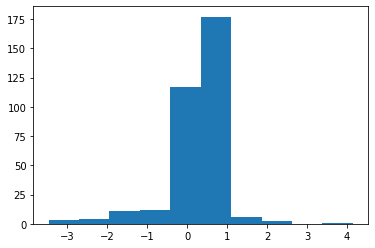

In [12]:
plt.hist(sharpes.sharpe);

In [13]:
sharpes.to_csv('sharpes.csv', index=False)

In [14]:
sharpes.shape

(335, 2)

In [15]:
MIX = sharpes.stock.tolist()[:200]
df = yf.download(MIX, start=START, end=TODAY)
df.drop(
    columns=['Open', 'Close', 'Volume', 'High', 'Low'], inplace=True)
df.columns = MIX
MAX_MISSING = 250
n_nan = df.isnull().sum()
drop = n_nan[n_nan > MAX_MISSING].index
df = df.drop(columns=drop)
print(df.shape)
df.head()

[*********************100%***********************]  200 of 200 completed

1 Failed download:
- BSD: No data found, symbol may be delisted
(2517, 116)


,bxsl,bbw,ASL,AFI,AMT,ASH,bwg,ARCH,ADM,brx,...,box,bsd,bvh,cir,mqy,btt,MT,mhd,bym,bta
Date,,,,,,,,,,,,,,,,,,,,,
2012-05-16,7.163316,11.468209,31.193605,4.623693,25.840000,18.558584,30.277416,17.371775,28.060949,7.155818,...,7.948895,9.583484,8.357766,8.997478,9.465910,8.640652,9.486775,8.566588,104.500000,118.579094
2012-05-17,7.061381,11.341177,31.082712,4.571233,25.350000,17.902430,29.696877,16.704397,27.521318,7.134132,...,7.966941,9.541264,8.340384,8.951373,9.465910,8.570639,9.428675,8.542502,102.510002,116.246727
2012-05-18,6.950176,11.284719,30.698874,4.579977,25.540001,17.456894,29.601252,16.574903,27.467352,7.268576,...,7.930840,9.583484,8.346174,8.876444,9.544836,8.541471,9.404726,8.542502,102.989998,110.362885
2012-05-21,7.045935,11.623472,30.775640,4.470685,26.400000,17.554098,29.983736,16.873732,28.006981,7.372661,...,7.900758,9.607608,8.375159,8.847619,9.516644,8.593977,9.376173,8.584641,105.980003,114.338448
2012-05-22,6.977979,11.595244,30.920645,4.463400,26.450001,17.489300,29.853952,16.465336,27.953028,7.138472,...,7.888713,9.535235,8.380952,8.899497,9.584302,8.623154,9.347036,8.584641,105.910004,114.444481


In [16]:
mu = mean_historical_return(df)
s = CovarianceShrinkage(df).ledoit_wolf()
ef = EfficientFrontier(mu, s)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
for k, v in dict(cleaned_weights).items():
    if v > 0:
        print(f'{k:6s}: {v}')

ASL   : 0.01253
AEG   : 0.02655
ACRE  : 0.0365
bke   : 0.10524
AYX   : 0.1074
ARL   : 0.14017
bit   : 0.03696
bmez  : 0.03899
bmy   : 0.02669
cmsd  : 0.14701
LFG   : 0.05093
brmk  : 0.00404
cabo  : 0.01765
ACR   : 0.22359
bui   : 0.02575


In [17]:
_, _, s1 = ef.portfolio_performance(verbose=True)

Expected annual return: 21.7%
Annual volatility: 16.0%
Sharpe Ratio: 1.23
